## **투빅스 16기 정규세션 Week2 Regression**

# Assignment3

1. sklearn 패키지를 사용해 로지스틱 회귀모형으로 데이터를 분석해 주세요 
2. 성능지표를 계산하고 이에 대해 해석해 주세요 
   - sklearn : mean accuracy, f1 score 등 다양한 성능지표 계산 
   - confusion matrix : tp, fp, fn, tn 값을 통해 성능지표 계산  
3. 어떤 성능지표를 기준으로 성능을 개선을 시도했고, 그러한 선택의 이유를 적어주세요.
4. **해석을 상세하게 달아주세요 !**

## Data 

출처 : https://www.kaggle.com/mlg-ulb/creditcardfraud


* V1 ~ V28 : 비식별화 된 개인정보 
* **Class** : Target 변수  
  - 1 : fraudulent transactions (사기)
  - 0 : otherwise 

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [2]:
data = pd.read_csv("assignment3_creditcard.csv")

In [3]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.848212,2.384900,0.379573,1.048381,-0.845070,2.537837,-4.542983,-10.201458,-1.504967,-2.234167,...,2.585817,-5.291690,0.859364,0.423231,-0.506985,1.020052,-0.627751,-0.017753,0.280982,0
1,2.071805,-0.477943,-1.444444,-0.548657,0.010036,-0.582242,-0.042878,-0.247160,1.171923,-0.342382,...,-0.077306,0.042858,0.390125,0.041569,0.598427,0.098803,0.979686,-0.093244,-0.065615,0
2,-2.985294,-2.747472,1.194068,-0.003036,-1.151041,-0.263559,0.553500,0.635600,0.438545,-1.806488,...,1.345776,0.373760,-0.385777,1.197596,0.407229,0.008013,0.762362,-0.299024,-0.303929,0
3,-1.479452,1.542874,0.290895,0.838142,-0.529290,-0.717661,0.484516,0.545092,-0.780767,0.324804,...,0.038397,0.116771,0.405560,-0.116453,0.541275,-0.216665,-0.415578,0.027126,-0.150347,0
4,-0.281976,-0.309699,-2.162299,-0.851514,0.106167,-1.483888,1.930994,-0.843049,-1.249272,1.079608,...,-0.875516,-0.004199,1.015108,-0.026748,0.077115,-1.468822,0.751700,0.496732,0.331001,0


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28678 entries, 0 to 28677
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      28678 non-null  float64
 1   V2      28678 non-null  float64
 2   V3      28678 non-null  float64
 3   V4      28678 non-null  float64
 4   V5      28678 non-null  float64
 5   V6      28678 non-null  float64
 6   V7      28678 non-null  float64
 7   V8      28678 non-null  float64
 8   V9      28678 non-null  float64
 9   V10     28678 non-null  float64
 10  V11     28678 non-null  float64
 11  V12     28678 non-null  float64
 12  V13     28678 non-null  float64
 13  V14     28678 non-null  float64
 14  V15     28678 non-null  float64
 15  V16     28678 non-null  float64
 16  V17     28678 non-null  float64
 17  V18     28678 non-null  float64
 18  V19     28678 non-null  float64
 19  V20     28678 non-null  float64
 20  V21     28678 non-null  float64
 21  V22     28678 non-null  float64
 22

In [182]:
tmp = data['Class'].value_counts().to_frame().reset_index()
tmp['Percent(%)'] = tmp["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
tmp = tmp.rename(columns = {"index" : "Target", "Class" : "Count"})

tmp

,Target,Count,Percent(%)
0,0,28432,99.14
1,1,246,0.86


사기인 경우는 0.86%로 데이터가 불균형함을 확인할 수 있다.

* 결측치 확인

In [26]:
def null_check(df):
    null = df.isnull().sum()
    
    null_col=[]

    for i in range(len(df.columns)):
        if (null[i]!=0):
            print(null.index[i],null[i],'개,',round(null[i]/len(data)*100,2), '%')
            null_col.append(null.index[i])
            
    if len(null_col) == 0:
        print("결측치 없음")

In [27]:
null_check(data)

결측치 없음


## **데이터 분할**

In [44]:
X_cols = data.columns[:-1].tolist()

In [50]:
X_data = data[X_cols]

In [62]:
X_data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,...,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000,28678.000000
mean,-0.015438,0.053653,-0.046031,0.037348,-0.033724,-0.003299,-0.051054,0.006064,-0.018530,-0.041149,...,0.007183,0.002633,0.010289,-0.000656,-0.004800,-0.000897,-0.001989,-0.000765,0.000948,0.001535
std,2.031529,1.616186,1.758169,1.482109,1.486998,1.339259,1.454827,1.364342,1.134065,1.252593,...,0.827420,0.720307,0.847152,0.739469,0.593663,0.603349,0.517968,0.483852,0.397075,0.296736
min,-30.552380,-42.172688,-31.103685,-5.560118,-42.147898,-21.929312,-41.506796,-39.267378,-13.434066,-24.403185,...,-4.619034,-21.387122,-21.453736,-8.887017,-36.666000,-2.718024,-6.712624,-2.241620,-7.418878,-9.617915
25%,-0.916927,-0.575381,-0.899872,-0.843321,-0.714901,-0.763757,-0.568146,-0.206103,-0.661909,-0.543450,...,-0.459073,-0.209678,-0.225520,-0.539244,-0.160583,-0.356047,-0.318619,-0.327343,-0.070558,-0.052189
50%,0.020050,0.075358,0.180610,-0.008844,-0.060040,-0.271363,0.036107,0.022463,-0.055095,-0.097390,...,0.002111,-0.062792,-0.028778,0.007302,-0.011199,0.040006,0.019770,-0.056260,0.002049,0.011075
75%,1.317461,0.806957,1.029928,0.771958,0.613328,0.397269,0.559409,0.329606,0.605704,0.460681,...,0.467781,0.131199,0.184312,0.526358,0.146835,0.437146,0.352717,0.240713,0.091637,0.078911
max,2.399484,21.467203,4.069865,11.927512,32.911462,22.529298,36.677268,20.007208,8.113152,15.236028,...,5.228342,26.237391,27.202839,8.361985,9.637187,3.948061,2.510401,3.122747,11.135740,14.929133


In [ ]:
# target 변수 numeric -> category
y_data = data['Class']
y_data = y_data.astype('category')

In [83]:
y_data.dtype

CategoricalDtype(categories=[0, 1], ordered=False)

In [52]:
y_data.value_counts()

0    28432
1      246
Name: Class, dtype: int64

In [78]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X_data, y_data, test_size=0.2,random_state=0)

In [184]:
pd.DataFrame([[sum(y_train == 0), sum(y_test == 0)], [sum(y_train == 1), sum(y_test == 1)]], 
             columns=['train', 'test'], index=['0 (otherwise)', '1 (fraud)'])

,train,test
0 (otherwise),22738,5694
1 (fraud),204,42


## **정규화**

### 1. Z-score 정규화

In [54]:
from sklearn.preprocessing import StandardScaler

s_scaler = StandardScaler()

In [55]:
s_scaler.fit(X_train)
X_train_ss = s_scaler.transform(X_train)
X_test_ss = s_scaler.transform(X_test)

In [67]:
pd.DataFrame(X_train_ss, columns = X_cols).describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,2.294200e+04,2.294200e+04,2.294200e+04,2.294200e+04,2.294200e+04,2.294200e+04,2.294200e+04,2.294200e+04,2.294200e+04,2.294200e+04,...,2.294200e+04,2.294200e+04,2.294200e+04,2.294200e+04,2.294200e+04,2.294200e+04,2.294200e+04,2.294200e+04,2.294200e+04,2.294200e+04
mean,1.902555e-17,3.173103e-17,3.726230e-18,-5.930513e-18,-3.886410e-17,-2.442858e-17,-1.316279e-17,-1.631254e-17,-2.532022e-17,2.031037e-17,...,-1.274177e-17,-1.031730e-17,-9.655760e-18,2.747490e-17,-4.222254e-17,9.925322e-18,-7.182793e-17,2.424469e-18,6.211190e-18,2.027983e-17
std,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,...,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00
min,-1.517044e+01,-1.649089e+01,-1.775915e+01,-3.784371e+00,-2.873951e+01,-1.074722e+01,-2.852504e+01,-2.809877e+01,-1.182546e+01,-1.942476e+01,...,-5.096179e+00,-3.053956e+01,-2.442527e+01,-1.197975e+01,-5.983940e+01,-4.405928e+00,-1.293812e+01,-3.312789e+00,-1.853767e+01,-3.158377e+01
25%,-4.505057e-01,-4.029434e-01,-4.890375e-01,-5.935939e-01,-4.651806e-01,-5.721897e-01,-3.543420e-01,-1.494242e-01,-5.674995e-01,-3.971541e-01,...,-5.651710e-01,-3.014459e-01,-2.713501e-01,-7.231380e-01,-2.510221e-01,-5.903839e-01,-6.087706e-01,-6.749412e-01,-1.785865e-01,-1.775408e-01
50%,1.768164e-02,1.282191e-02,1.299755e-01,-3.539583e-02,-1.557343e-02,-2.040673e-01,6.311913e-02,1.553498e-02,-2.961248e-02,-4.394846e-02,...,-6.713531e-03,-9.322504e-02,-4.777072e-02,1.109330e-02,-8.356701e-03,6.382069e-02,4.313675e-02,-1.112337e-01,2.674957e-03,3.111585e-02
75%,6.599516e-01,4.801646e-01,6.145996e-01,4.964767e-01,4.420154e-01,3.022863e-01,4.221079e-01,2.342291e-01,5.515835e-01,4.001310e-01,...,5.589014e-01,1.851617e-01,1.969259e-01,7.086233e-01,2.478910e-01,7.259376e-01,6.858610e-01,4.967523e-01,2.248024e-01,2.561502e-01
max,1.196630e+00,1.363562e+01,2.355747e+00,8.033104e+00,1.443260e+01,1.687265e+01,2.527632e+01,1.431648e+01,7.169665e+00,1.218529e+01,...,6.335407e+00,1.672660e+01,3.093969e+01,1.128239e+01,1.574101e+01,6.557019e+00,4.808085e+00,6.459839e+00,2.781833e+01,4.900858e+01


### 2. 최대최소 정규화

In [56]:
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()

In [57]:
mm_scaler.fit(X_train)
X_train_mms = mm_scaler.transform(X_train)
X_test_mms = mm_scaler.transform(X_test)

In [58]:
print(X_train_mms.min(axis=0))
print(X_train_mms.max(axis=0))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [59]:
print(X_test_mms.min(axis=0))
print(X_test_mms.max(axis=0))

[ 0.06154773 -0.3454811   0.02633705  0.03789942  0.27062763 -0.20541912
  0.13186149  0.18948322  0.18431584  0.05590667 -0.02145405  0.103056
  0.03343946  0.15852006  0.03517495  0.07407103  0.06949076  0.0355305
 -0.04526278  0.45859461  0.15198206  0.11366824  0.5476008  -0.01043547
  0.20256412 -0.13498135  0.00837504  0.2322582 ]
[0.99928651 0.89492943 0.9947092  0.9930212  1.18637096 0.78421499
 0.82750581 0.97877106 0.98180046 0.9200847  0.83913183 0.95924839
 1.00588951 0.93364703 0.91284741 0.90865292 0.94726222 0.97565396
 0.88341839 1.43860913 0.68449499 0.79348424 0.94631553 0.94386922
 1.00202791 0.98790373 0.63967656 0.58859454]


In [66]:
pd.DataFrame(X_train_mms, columns = X_cols).describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,22942.000000,22942.000000,22942.000000,22942.000000,22942.000000,22942.000000,22942.000000,22942.000000,22942.000000,22942.000000,...,22942.000000,22942.000000,22942.000000,22942.000000,22942.000000,22942.000000,22942.000000,22942.000000,22942.000000,22942.000000
mean,0.926888,0.547388,0.882885,0.320235,0.665696,0.389112,0.530192,0.662469,0.622552,0.614512,...,0.445798,0.646119,0.441168,0.514989,0.791732,0.401893,0.729064,0.338987,0.399898,0.391895
std,0.061100,0.033194,0.049715,0.084622,0.023164,0.036207,0.018587,0.023577,0.052646,0.031636,...,0.087479,0.021157,0.018062,0.042989,0.013231,0.091218,0.056351,0.102329,0.021573,0.012408
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.899363,0.534013,0.858573,0.270005,0.654921,0.368395,0.523606,0.658946,0.592676,0.601948,...,0.396359,0.639741,0.436267,0.483903,0.788410,0.348040,0.694760,0.269922,0.396045,0.389692
50%,0.927968,0.547814,0.889347,0.317240,0.665336,0.381723,0.531365,0.662835,0.620993,0.613122,...,0.445211,0.644147,0.440306,0.515466,0.791621,0.407714,0.731495,0.327604,0.399956,0.392281
75%,0.967210,0.563326,0.913440,0.362247,0.675935,0.400056,0.538037,0.667991,0.651591,0.627171,...,0.494689,0.650036,0.444725,0.545452,0.795011,0.468110,0.767712,0.389818,0.404747,0.395074
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## **Logistic Regression**

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
### 1. Z-score 정규화

In [113]:
LR_model1 = LogisticRegression(random_state=0)
LR_model2 = LogisticRegression(random_state=0)
LR_model3 = LogisticRegression(random_state=0)

lr1 = LR_model1.fit(X_train, y_train)
lr2 = LR_model2.fit(X_train_ss, y_train)
lr3 = LR_model3.fit(X_train_mms, y_train)

* 회귀계수 확인

In [114]:
# lr2(z-score 정규화) 칼럼에 따른 beta, exp(beta) 확인
column_name=["const"]+X_cols
beta=np.concatenate([lr2.intercept_,lr2.coef_.reshape(-1)]).round(2)
odds=np.exp(beta).round(2)
interpret=np.where(beta>0,"risky","protective")

#beta 해석
beta_analysis=pd.DataFrame(np.c_[beta,odds,interpret],index=column_name,columns=["beta","exp(beta)","interprt"])
beta_analysis

,beta,exp(beta),interprt
const,-7.33,0.0,protective
V1,0.03,1.03,risky
V2,-0.12,0.89,protective
V3,0.02,1.02,risky
V4,1.24,3.46,risky
V5,0.04,1.04,risky
V6,-0.29,0.75,protective
V7,0.03,1.03,risky
V8,-0.27,0.76,protective
V9,0.0,1.0,protective


In [115]:
test_pred1 = lr1.predict(X_test)
test_pred2 = lr2.predict(X_test)
test_pred3 = lr3.predict(X_test)

In [116]:
# lr2 (z-score 정규화) 
lr2.predict_proba(X_test)

array([[9.99123701e-01, 8.76298837e-04],
       [9.99656597e-01, 3.43402653e-04],
       [9.62055423e-01, 3.79445775e-02],
       ...,
       [9.99625363e-01, 3.74636505e-04],
       [9.98107197e-01, 1.89280264e-03],
       [9.99600710e-01, 3.99290405e-04]])

## **Evaluation**

In [ ]:
1. 정규화 x

In [117]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, test_pred1)
confusion

array([[5690,    4],
       [   7,   35]])

In [118]:
from sklearn.metrics import classification_report

print(classification_report(y_test, test_pred1, target_names=['fraudulent', 'otherwise']))

              precision    recall  f1-score   support

  fraudulent       1.00      1.00      1.00      5694
   otherwise       0.90      0.83      0.86        42

    accuracy                           1.00      5736
   macro avg       0.95      0.92      0.93      5736
weighted avg       1.00      1.00      1.00      5736



정규화를 하지 않은 모델도 accuracy:1, precision:1, recall:1 로 높은 성능을 보였다.

In [ ]:
2. Z-score Scaled

In [119]:
confusion = confusion_matrix(y_test, test_pred2)
confusion

array([[5685,    9],
       [   4,   38]])

In [121]:
print(classification_report(y_test, test_pred2, target_names=['fraudulent', 'otherwise']))

              precision    recall  f1-score   support

  fraudulent       1.00      1.00      1.00      5694
   otherwise       0.81      0.90      0.85        42

    accuracy                           1.00      5736
   macro avg       0.90      0.95      0.93      5736
weighted avg       1.00      1.00      1.00      5736



Z-score 정규화를 적용한 모델도 굉장히 높은 성능을 보였다.

In [ ]:
3. MinMax Scaled

In [126]:
confusion = confusion_matrix(y_test, test_pred3)
confusion

array([[ 350, 5344],
       [   0,   42]])

In [122]:
print(classification_report(y_test, test_pred3, target_names=['fraudulent', 'otherwise']))

              precision    recall  f1-score   support

  fraudulent       1.00      0.06      0.12      5694
   otherwise       0.01      1.00      0.02        42

    accuracy                           0.07      5736
   macro avg       0.50      0.53      0.07      5736
weighted avg       0.99      0.07      0.12      5736



최대최소정규화를 적용한 모델은 정확도가 0.07로 매우 낮은 성능을 보였다.

## **Cut-Off 조정**

In [185]:
def ad_cut_off(model, y_pred):
    beta=np.concatenate([model.intercept_,model.coef_.reshape(-1)]).round(2)
    Xbeta=np.matmul(np.c_[np.ones(X_test.shape[0]),X_test],beta.reshape(-1,1))
    P_1=1/(1+np.exp(-Xbeta))
    P_1
    
    Cut_off=np.linspace(0.01,0.99,10)
    for cutoff in Cut_off:
        y_pred=np.where(P_1.reshape(-1)>=cutoff,1,0)
        #cutoff 보다 크면 사기로 판별
        acc=accuracy_score(y_true=y_test,y_pred=y_pred) #정확도
        recall=recall_score(y_true=y_test,y_pred=y_pred) #민감도
        precision=precision_score(y_true=y_test,y_pred=y_pred) #정밀도

        print(f"Acc : {acc : 0.2f}",f"Recall : {recall : 0.2f}",f"Precision : {precision : 0.2f}",f"cut off : {cutoff : 0.2f}")

In [179]:
def plot_roc_curve(model, X_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test,model.decision_function(X_test))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn/(fp+tn)
    recall = tp/(tp+fn)
    
    plt.plot(fpr, tpr, color='green', label='ROC')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.plot([1-specificity], [recall], 'ro', ms=10) # 현재 cutoff value 값 


    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
    print('AUC:', roc_auc_score(y_test, y_pred, average=None))

1. 정규화 x

In [186]:
ad_cut_off(lr1, test_pred1)

Acc :  0.97 Recall :  1.00 Precision :  0.20 cut off :  0.01
Acc :  1.00 Recall :  0.90 Precision :  0.81 cut off :  0.12
Acc :  1.00 Recall :  0.88 Precision :  0.86 cut off :  0.23
Acc :  1.00 Recall :  0.83 Precision :  0.85 cut off :  0.34
Acc :  1.00 Recall :  0.83 Precision :  0.90 cut off :  0.45
Acc :  1.00 Recall :  0.81 Precision :  0.89 cut off :  0.55
Acc :  1.00 Recall :  0.76 Precision :  0.94 cut off :  0.66
Acc :  1.00 Recall :  0.67 Precision :  0.93 cut off :  0.77
Acc :  1.00 Recall :  0.62 Precision :  0.93 cut off :  0.88
Acc :  1.00 Recall :  0.55 Precision :  0.96 cut off :  0.99


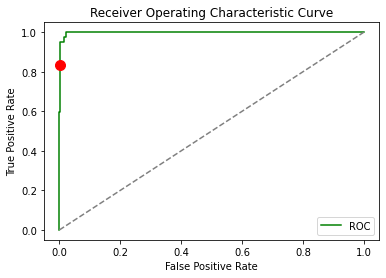

AUC: 0.9163154197400774


In [180]:
plot_roc_curve(lr1, X_test, test_pred1)

2. Z-score 정규화

In [187]:
ad_cut_off(lr2, test_pred2)

Acc :  0.93 Recall :  1.00 Precision :  0.09 cut off :  0.01
Acc :  0.99 Recall :  0.95 Precision :  0.54 cut off :  0.12
Acc :  1.00 Recall :  0.95 Precision :  0.71 cut off :  0.23
Acc :  1.00 Recall :  0.93 Precision :  0.78 cut off :  0.34
Acc :  1.00 Recall :  0.90 Precision :  0.79 cut off :  0.45
Acc :  1.00 Recall :  0.88 Precision :  0.84 cut off :  0.55
Acc :  1.00 Recall :  0.88 Precision :  0.84 cut off :  0.66
Acc :  1.00 Recall :  0.86 Precision :  0.86 cut off :  0.77
Acc :  1.00 Recall :  0.83 Precision :  0.85 cut off :  0.88
Acc :  1.00 Recall :  0.64 Precision :  0.87 cut off :  0.99


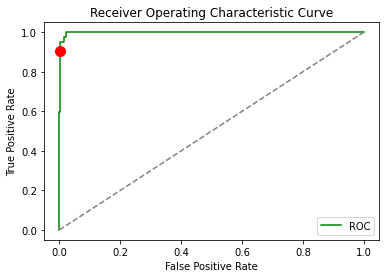

AUC: 0.9515906467961263


In [181]:
plot_roc_curve(lr2, X_test_ss, test_pred2)

## **Cut-Off 선정**

**<Cut-Off: 0.23>** <br>
    Accuracy: 1 <br>
    Recall: 0.95 <br>
    Precision: 0.71 <br>

class가 1(사기)인 비율은 0.86%로 매우 적으므로 Recall값을 기준으로 최종 모델과 cut-off를 선정하였다.  <br>
Z-score 정규화를 적용 모델, cutoff: 0.23



In [215]:
def draw_matrix(thrsh, model):
    TP = 0
    TN = 0
    FN = 0
    FP = 0

    proba = model.predict_proba(X_test)
    arr_y_test = np.array(y_test)
    
    for i,p in enumerate(proba):
        if p[1] > thrsh and arr_y_test[i] == 1:
            TP += 1
        elif p[1] < thrsh and arr_y_test[i] == 0:
            TN += 1
        elif p[1] < thrsh and arr_y_test[i] == 1:
            FN += 1
        elif p[1] > thrsh and arr_y_test[i] == 0:
            FP += 1
            
    print('** Threshold : %.2f **' %thrsh)
    print('acc:', (TP+TN)/(TP+TN+FP+FN))
    print('recall:', TP/(TP+FN)) 
    print('Precision:', TP/(TP+FP))
    print("specificity: ", TN/(FP+TN)
)

    print('\n')

In [216]:
draw_matrix(0.23, lr2)

** Threshold : 0.23 **
acc: 0.9968619246861925
recall: 0.9523809523809523
Precision: 0.7142857142857143
specificity:  0.9971900245872849




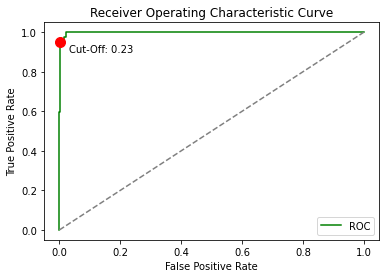

In [225]:
fpr, tpr, thresholds = roc_curve(y_test,lr2.decision_function(X_test_ss))

specificity = 0.9971900245872849
recall = 0.9523809523809523

plt.plot(fpr, tpr, color='green', label='ROC')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.plot([1-specificity], [recall], 'ro', ms=10) # 현재 cutoff value 값 

plt.text(0.03, 0.9, 'Cut-Off: 0.23')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

최종 모델: Z-score 정규화를 적용하고 cut-off를 0.23으로 설정한 로지스틱회귀모델